In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install timm

In [ ]:
!pip install tensorflow --upgrade
!pip install keras --upgrade

In [ ]:
pip install git+https://github.com/ChristophReich1996/Swin-Transformer-V2

In [5]:
project_dir = '/content/drive/MyDrive/01_Deep_Learning/model_swin'
data_dir = project_dir + '/' + 'Dataset'

In [8]:
from swin_transformer_v2 import SwinTransformerV2

from swin_transformer_v2 import swin_transformer_v2_t, swin_transformer_v2_s, swin_transformer_v2_b, \
    swin_transformer_v2_l, swin_transformer_v2_h, swin_transformer_v2_g

In [9]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

Image_resolution = 224 x 224 (change to 128 x 128)
patch_size = 4 x 4 (or 2 x 2)
number of features in one patch = 4 x 4 x 3 = 48
total number of patches in the whole image = 224/4 x 224/4 = 313

In [16]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load the image file
image_path = project_dir + '/CNV-28682-10.jpeg'
image = Image.open(image_path)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 128x128
    transforms.ToTensor()  # Convert the image to a tensor
])

# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

# Print the shape and data type of the tensor
print("Tensor shape:", tensor_image.shape)
print("Tensor data type:", tensor_image.dtype)

# Permute dimensions to match the expected shape (B, H, W, C)
tensor_image = tensor_image.permute(0, 2, 3, 1)

Tensor shape: torch.Size([1, 1, 224, 224])
Tensor data type: torch.float32


In [21]:
def window_partition(x, patch_size=4):
    """
    Args:
        x: (B, H, W, C)
        patch_size (int): patch size (Default: 4)

    Returns:
        patches: (num_patches * B, patch_size, patch_size, C)
                 (num_windows * B, patch_size, patch_size, C)
    """

    B, H, W, C = x.shape

    # Calculate the number of patches in each dimension
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size

    # Convert to (B, num_patches_h, patch_size, num_patches_w, patch_size, C)
    x = x.view(B, num_patches_h, patch_size, num_patches_w, patch_size, C)

    # Convert to (B, num_patches_h, num_patches_w, patch_size, patch_size, C)
    patches = x.permute(0, 1, 3, 2, 4, 5).contiguous()

    # Efficient Batch Computation - Convert to (B * num_patches_h * num_patches_w, patch_size, patch_size, C)
    patches = patches.view(-1, patch_size, patch_size, C)

    return patches

Windows shape: torch.Size([3136, 4, 4, 1])
num_patches  3136


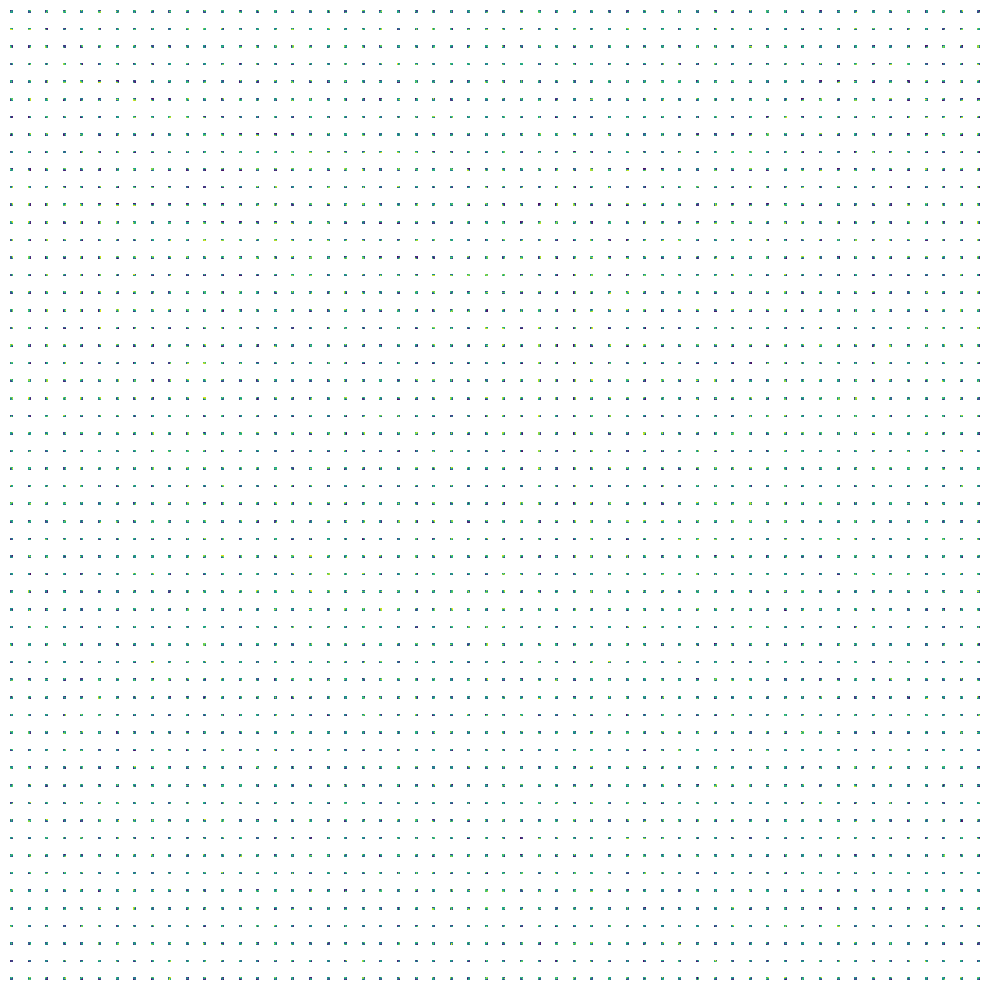

In [22]:
# Call the window_partition function on the tensor_image
window_size = 4
windows = window_partition(tensor_image, window_size)

num_patches, patch_size, _, _ = windows.shape

# Print the shape of the output windows
print("Windows shape:", windows.shape)

print("num_patches ",num_patches)

# Calculate the number of rows and columns in the grid
num_rows = int(num_patches ** 0.5)
num_cols = num_patches // num_rows

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over the patches and plot them
for i, ax in enumerate(axs.flat):
    patch = windows[i].numpy()
    ax.imshow(patch)
    ax.axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# (128/4 * 128/4 =32*32 = 1024 patches of size 4*4)
# (224/4 * 224/4 =56*56 = 3136 patches of size 4*4)

## Display Patches for Visualization

Total number of windows: 3136


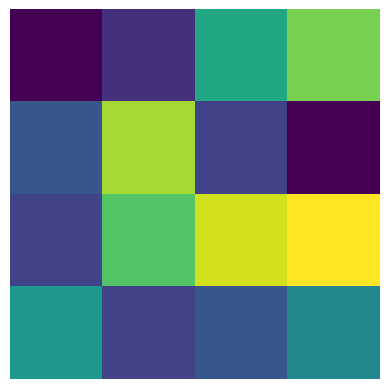

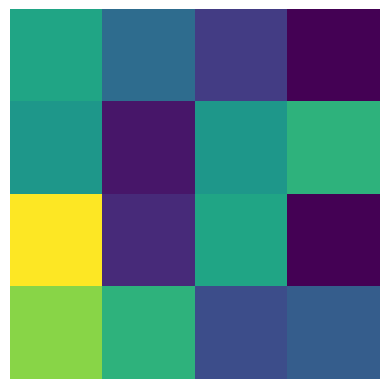

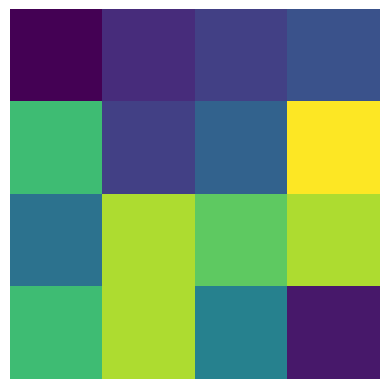

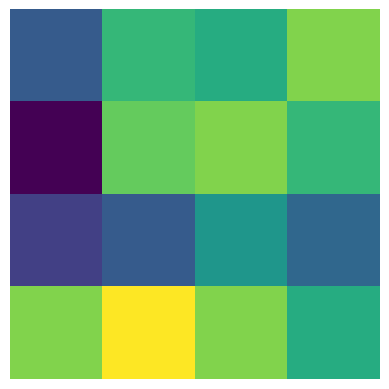

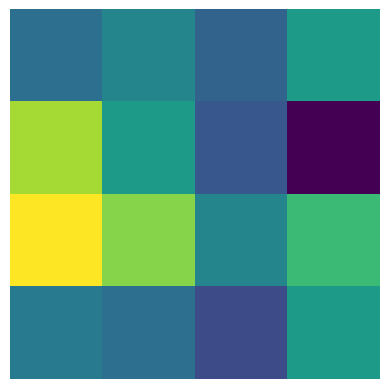

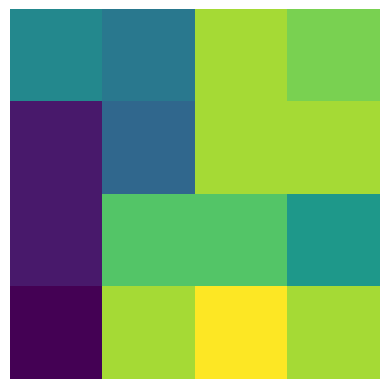

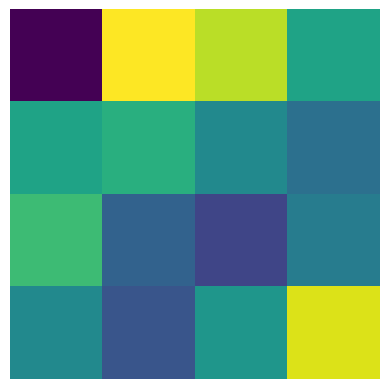

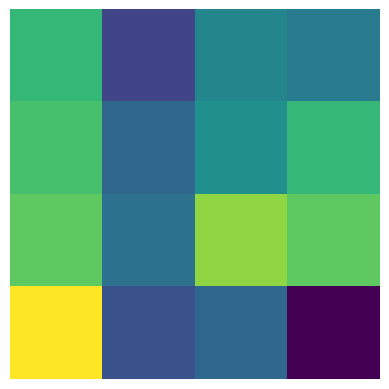

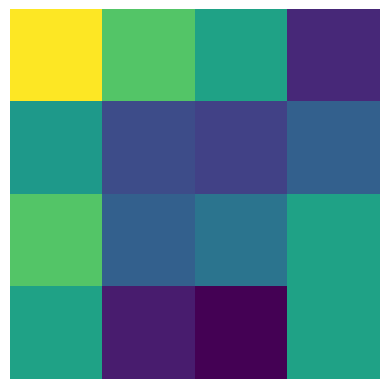

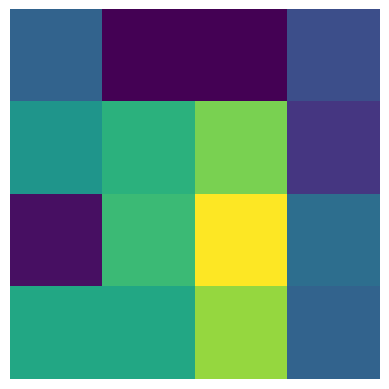

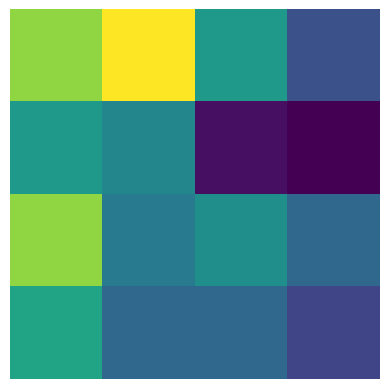

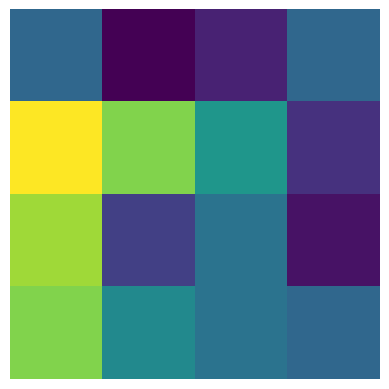

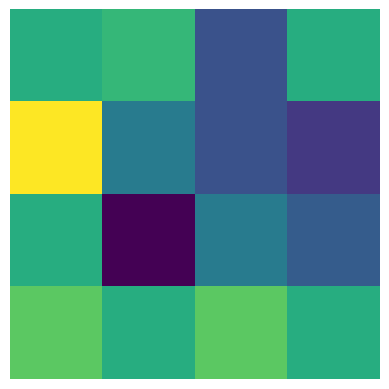

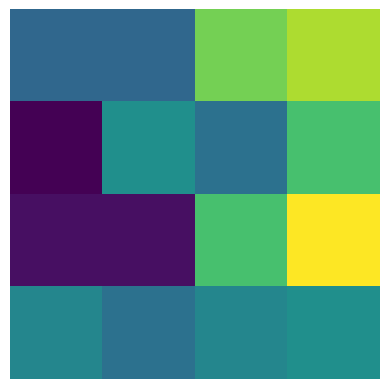

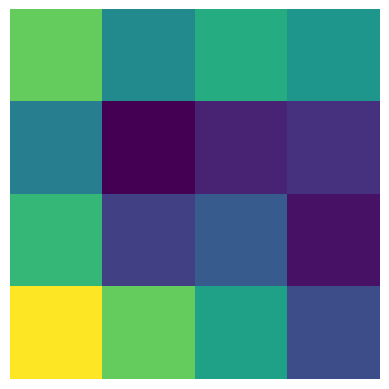

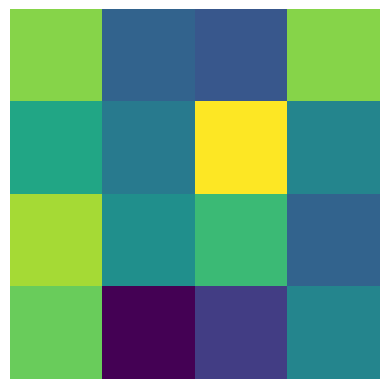

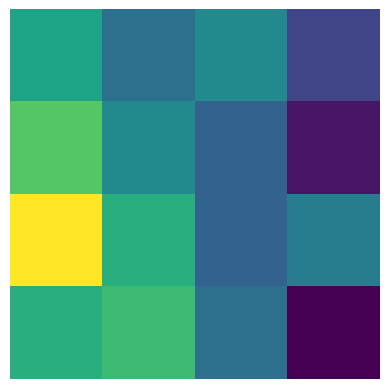

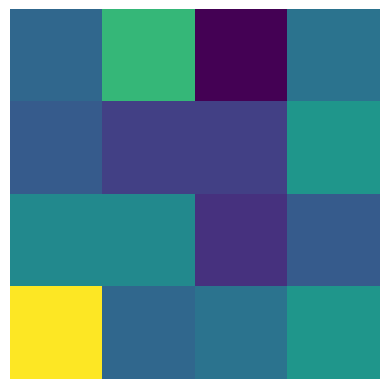

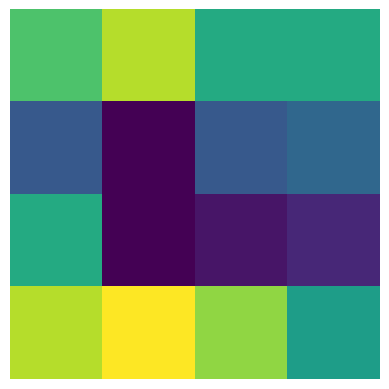

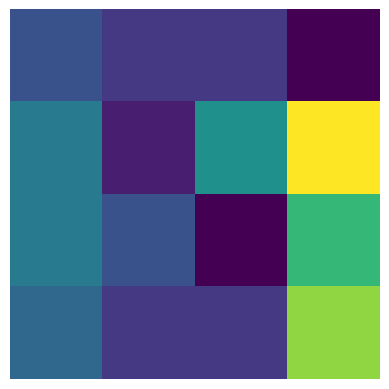

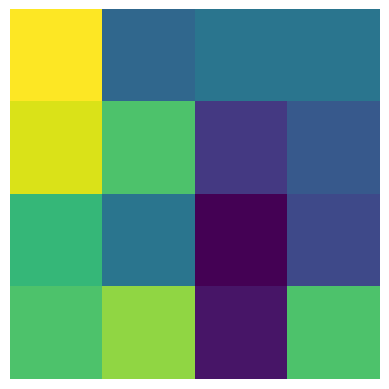

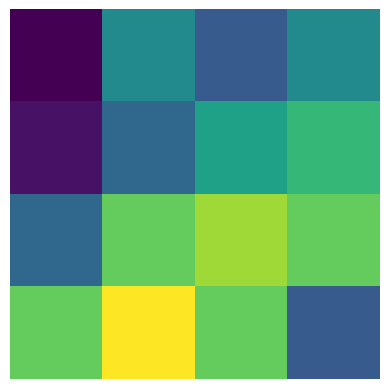

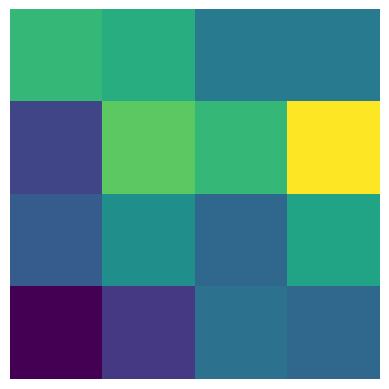

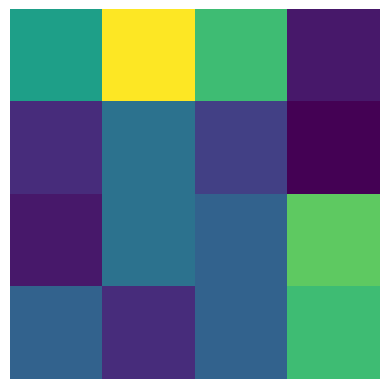

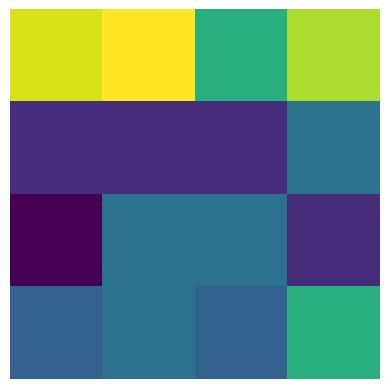

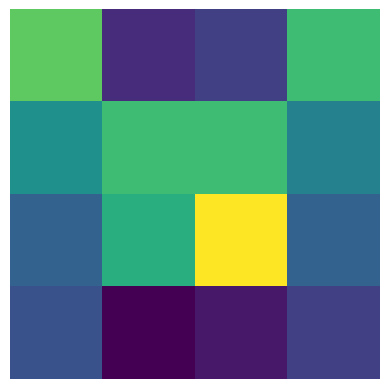

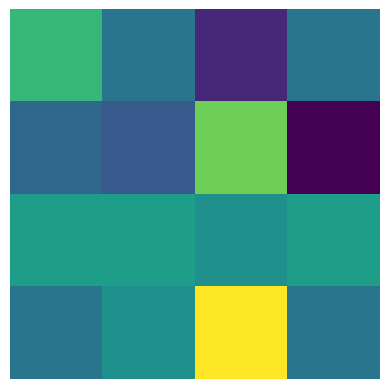

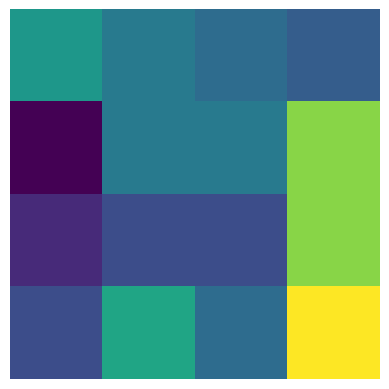

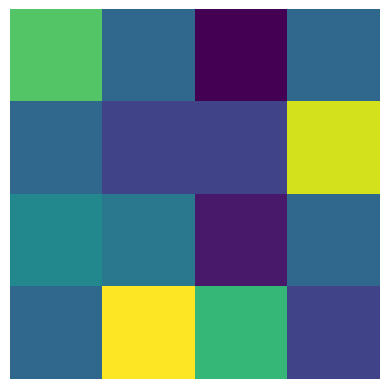

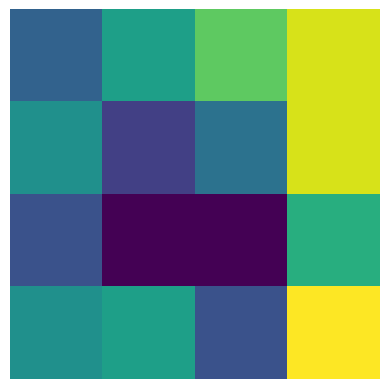

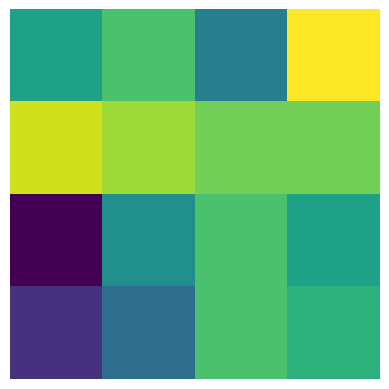

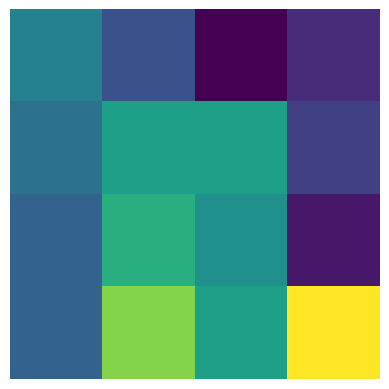

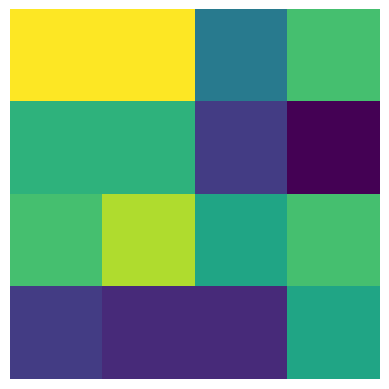

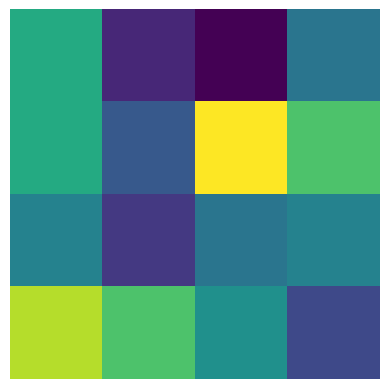

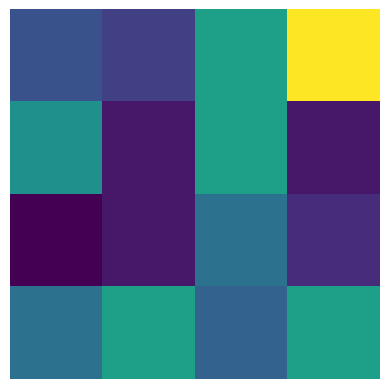

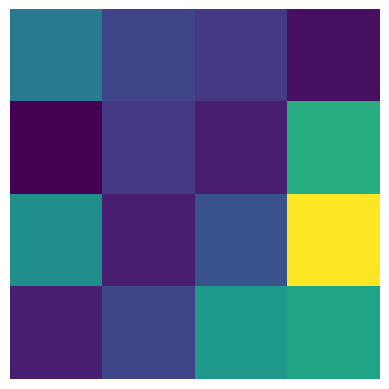

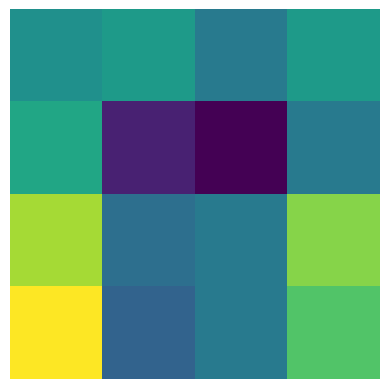

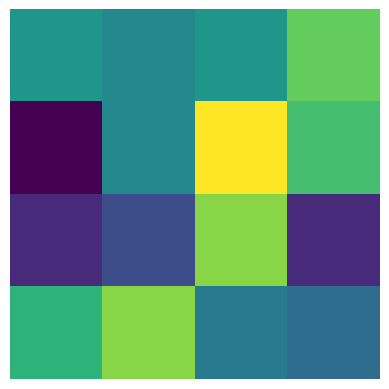

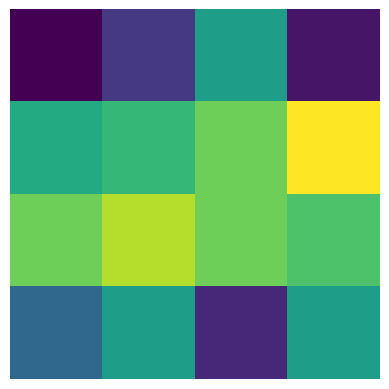

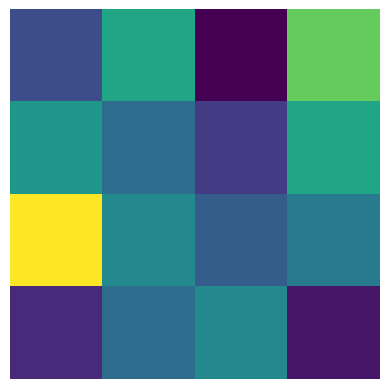

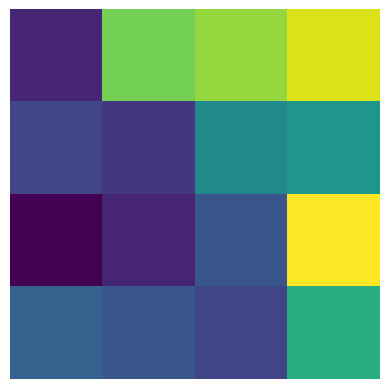

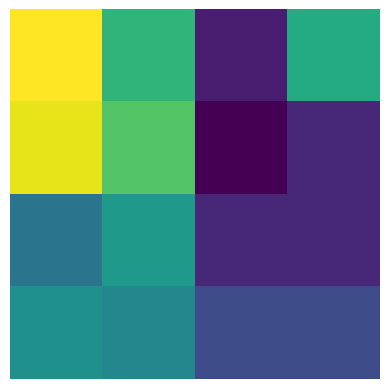

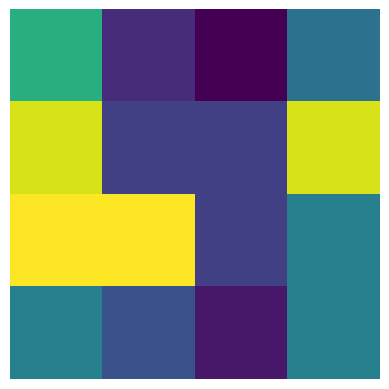

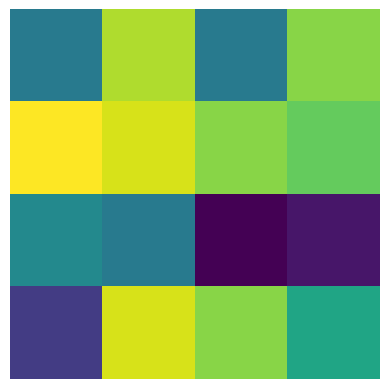

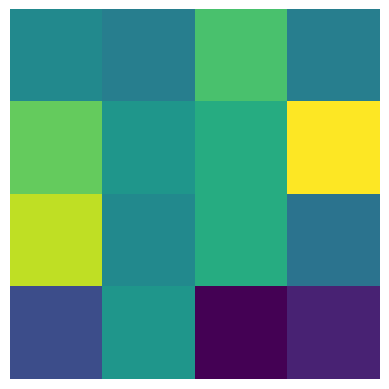

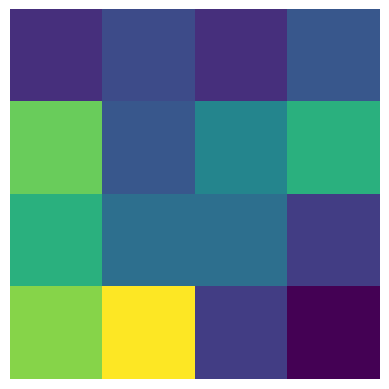

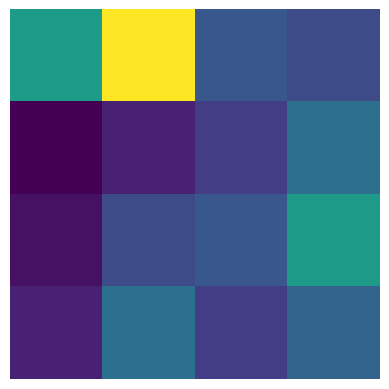

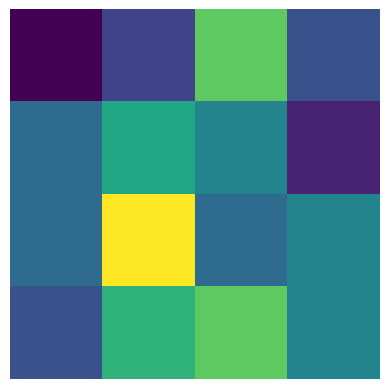

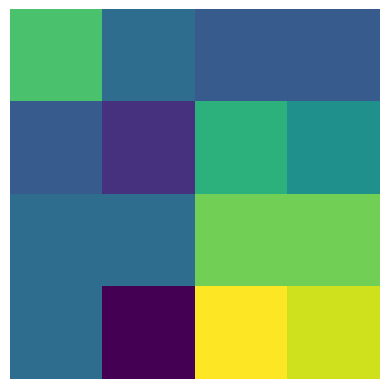

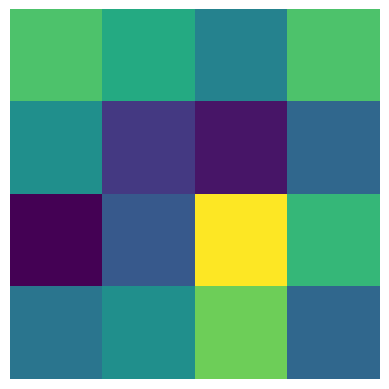

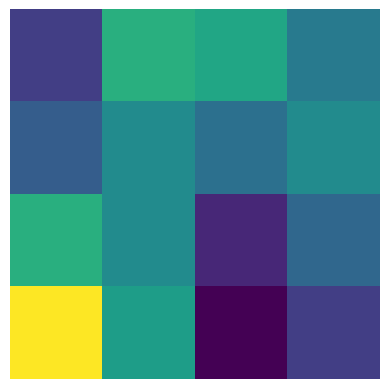

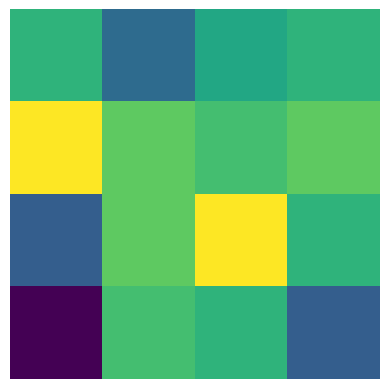

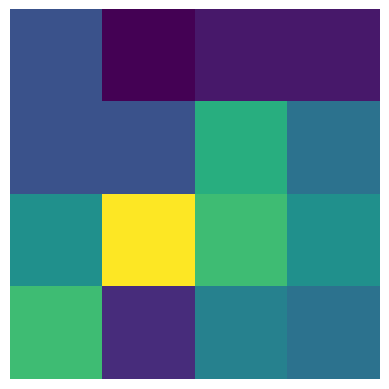

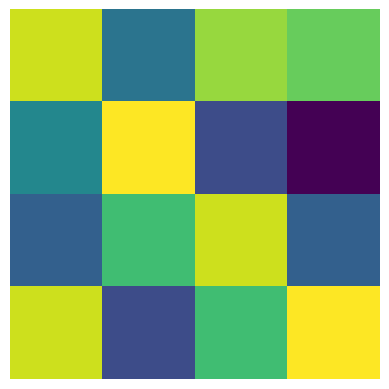

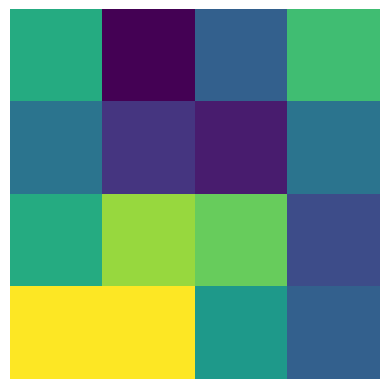

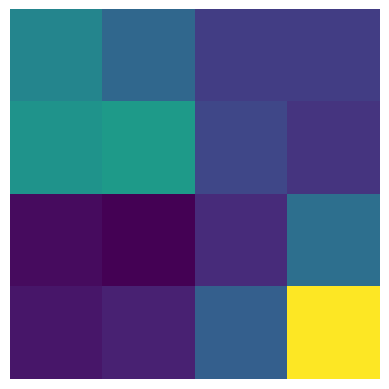

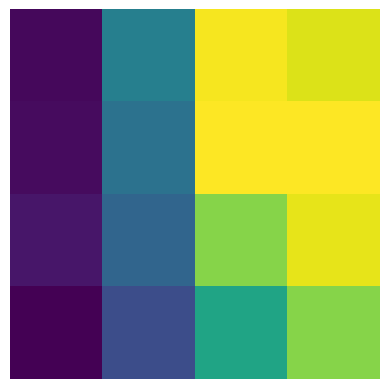

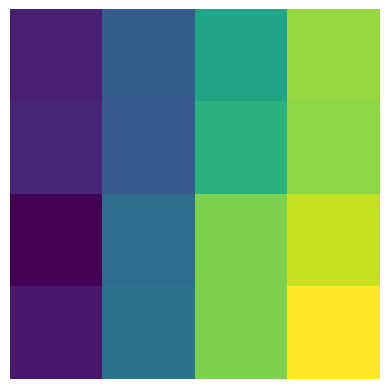

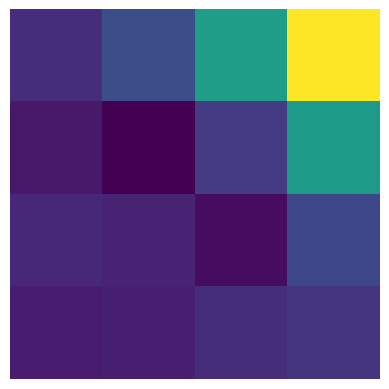

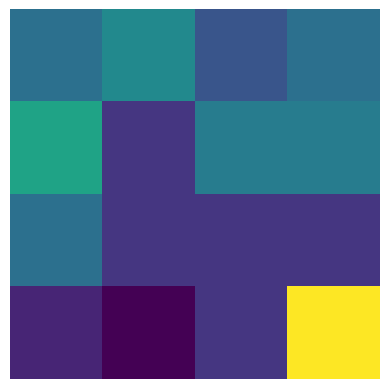

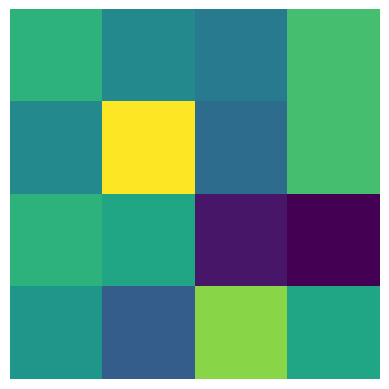

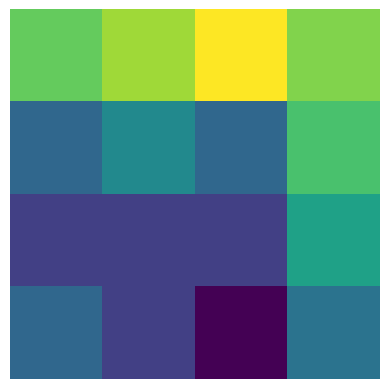

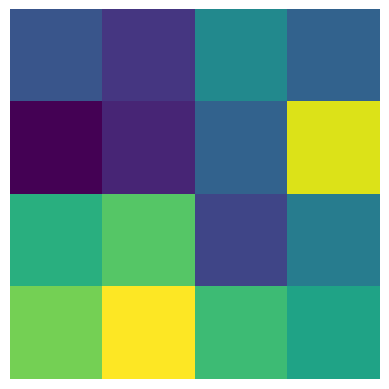

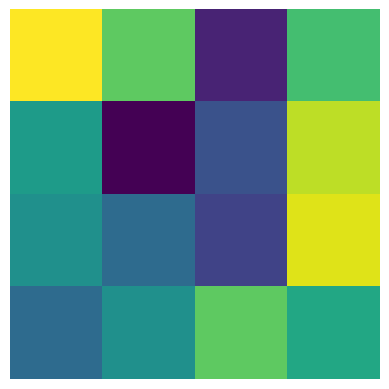

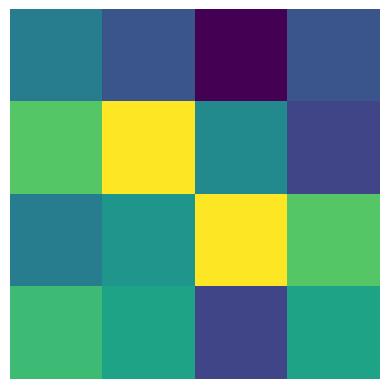

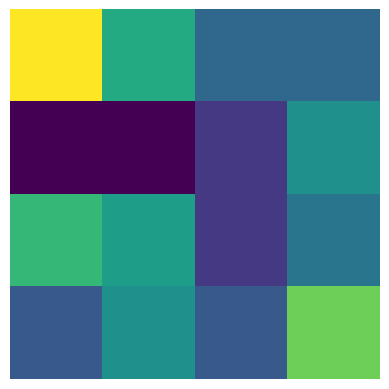

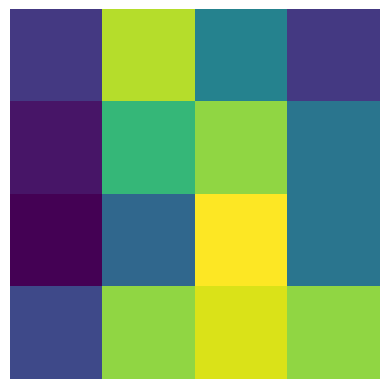

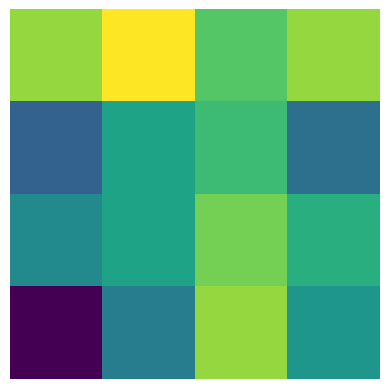

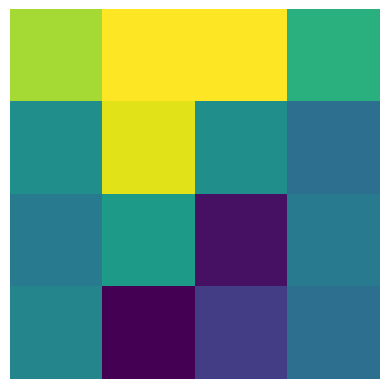

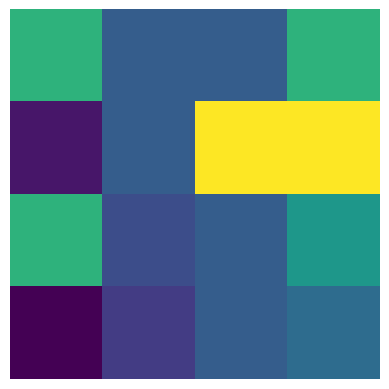

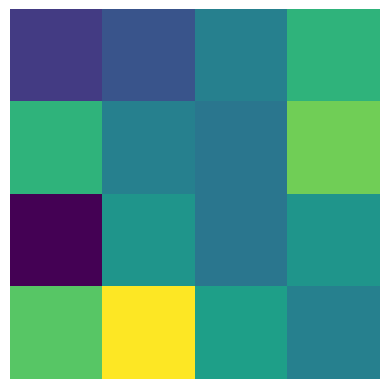

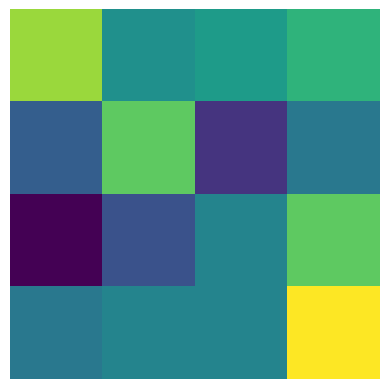

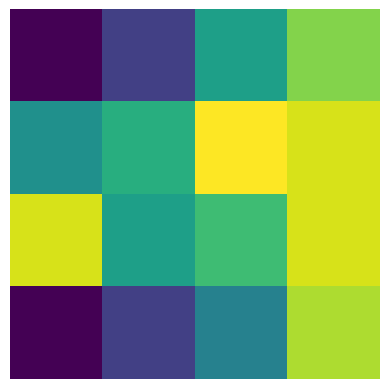

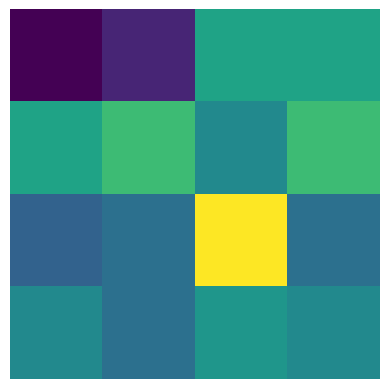

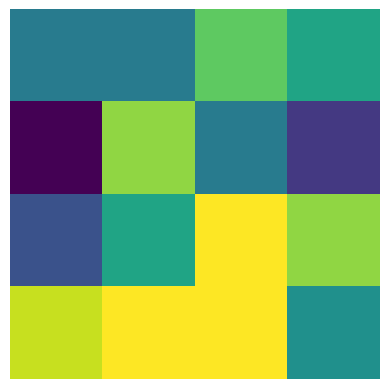

KeyboardInterrupt: ignored

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already obtained the windows tensor

# Iterate over the windows and display them
num_windows = windows.shape[0]
print("Total number of windows:", num_windows)
for i in range(num_windows):
    window = windows[i]  # Get a single window

    # Convert the window tensor to a numpy array and transpose dimensions
    window_np = window.numpy().transpose(1, 0, 2)

    # Normalize the window values to [0, 1] range
    window_np = (window_np - window_np.min()) / (window_np.max() - window_np.min())

    # Display the window image
    plt.imshow(window_np)
    plt.axis('off')
    plt.show()

## Linear Embedding
(4 x 4 x 3 Tensor to 1 x 1 x 96)

In [25]:
# Lets use PatchEmbed

class PatchEmbed(nn.Module):
    """ Convert image to patch embedding

    Args:
        img_size (int): Image size (Default: 224)
        patch_size (int): Patch token size (Default: 4)
        in_channels (int): Number of input image channels (Default: 3)
        embed_dim (int): Number of linear projection output channels (Default: 96)
        norm_layer (nn.Module, optional): Normalization layer (Default: None)
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=64, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size) # (img_size, img_size) to_2tuple simply convert t to (t,t)
        patch_size = to_2tuple(patch_size) # (patch_size, patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]] # (num_patches, num_patches)

        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        # proj layer: (B, 3, 224, 224) -> (B, 96, 56, 56)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        """
        x: (B, C, H, W) Default: (B, 3, 224, 224)
        returns: (B, H//patch_size * W//patch_size, embed_dim) (B, 56*56, 96)
        """
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}]) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."

        # (B, 3, 224, 224) -> (B, 96, 56, 56)
        x = self.proj(x)

        # (B, 96, 56, 56) -> (B, 96, 56*56)
        x = x.flatten(2)

        # (B, 96, 56*56) -> (B, 56*56, 96): 56 refers to the number of patches
        x = x.transpose(1, 2)

        if self.norm is not None:
            x = self.norm(x)

        return x

## Apply patch embedding on patches

In [26]:
# Load the image file
image_path = project_dir + '/CNV-28682-10.jpeg'
image = Image.open(image_path)

# Convert single-channel image to RGB
rgb_image = Image.merge("RGB", (image, image, image))
gray_image = image.convert("L")

# Convert PIL Image to numpy array
rgb_array = np.array(rgb_image)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 128x128
    transforms.ToTensor()  # Convert the image to a tensor
])

# Apply the transformation to the image
tensor_image = transform(rgb_image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

patch_embed = PatchEmbed(img_size=224, patch_size=4, in_chans=3, embed_dim=96)

embedding = patch_embed(tensor_image)


patches = patch_embed(tensor_image)
# Print the shape of the output patches
print("Patches shape:", patches.shape)   # 64 is embedding dimension, 3136 patches 224/4 * 224/4

embedding

Patches shape: torch.Size([1, 3136, 96])


tensor([[[-0.0549,  0.0880,  0.0984,  ..., -0.1688, -0.0333, -0.1048],
         [-0.0527,  0.0692,  0.0853,  ..., -0.1601, -0.0111, -0.0993],
         [-0.0510,  0.0552,  0.0864,  ..., -0.1578, -0.0406, -0.0995],
         ...,
         [-0.0188,  0.0755,  0.1041,  ..., -0.1356, -0.0686, -0.1205],
         [-0.0221,  0.0732,  0.1086,  ..., -0.1359, -0.0710, -0.1214],
         [-0.0215,  0.0714,  0.1069,  ..., -0.1366, -0.0757, -0.1245]]],
       grad_fn=<TransposeBackward0>)

In [27]:
tensor_image.size()

torch.Size([1, 3, 224, 224])

In [28]:
print("First patch embedding vector:", patches[0, 0])

# 64 values in every patch because 64 is embedding dimension we mentioned above

#To access the second patch's embedding vector, you can use patches[0, 1]

First patch embedding vector: tensor([-0.0549,  0.0880,  0.0984, -0.0711, -0.0877, -0.0023,  0.0077, -0.0961,
         0.0026, -0.0323,  0.0461,  0.0520, -0.1554, -0.1123, -0.0426,  0.1133,
        -0.0533, -0.1445,  0.0487,  0.0890,  0.0767, -0.0031, -0.1338, -0.1793,
         0.1031,  0.0161,  0.0949,  0.0529, -0.0948, -0.0588, -0.1496, -0.1257,
         0.0535, -0.0168,  0.0193, -0.1542, -0.0673,  0.0151, -0.0845,  0.0990,
        -0.0812,  0.1562,  0.0353,  0.1188,  0.1082,  0.1050,  0.1598, -0.1261,
        -0.0876, -0.0622,  0.0227, -0.1613, -0.1177, -0.1540,  0.0671, -0.1526,
         0.0817,  0.0108, -0.0946, -0.0013, -0.1450,  0.0603, -0.0748,  0.0864,
        -0.0859, -0.1078, -0.0165, -0.1291, -0.0175,  0.0412,  0.1182,  0.0067,
        -0.0599, -0.1458, -0.0238, -0.2253, -0.1320, -0.0492,  0.1249, -0.0158,
        -0.1236,  0.0432, -0.1136, -0.0245,  0.0455,  0.1581,  0.0248, -0.1603,
         0.0069,  0.1049,  0.0630, -0.1379, -0.0950, -0.1688, -0.0333, -0.1048],
       gr

## Using BasicLayer : Swin Transformer layer for one stage

In [14]:
import sys
# Append the directory to your python path using sys
sys.path.append('/content/drive/MyDrive/01_Deep_Learning/model_swin')
# Import the module
import swin_functions_and_classes

In [15]:
from swin_functions_and_classes import *

In [31]:
stage_1 = BasicLayer(dim=96, input_resolution=(56, 56), depth=2, num_heads=4, window_size=7)

# Pass the patch embeddings through the BasicLayer
output = stage_1(embedding)
print(output.shape)
output

torch.Size([1, 3136, 96])


tensor([[[-0.7485, -0.0444,  0.2617,  ..., -0.2606,  0.8121,  0.6155],
         [-0.7746, -0.0464,  0.2525,  ..., -0.2668,  0.8408,  0.6286],
         [-0.7739, -0.0711,  0.2440,  ..., -0.2589,  0.8156,  0.6201],
         ...,
         [-0.8087, -0.3695, -0.2128,  ...,  0.0156,  0.2317,  0.3274],
         [-0.8115, -0.3720, -0.2133,  ...,  0.0179,  0.2281,  0.3253],
         [-0.8094, -0.3735, -0.2214,  ...,  0.0178,  0.2241,  0.3171]]],
       grad_fn=<AddBackward0>)

## Patch Merging

In [32]:
# USing patch merging on the embedding
merge_layer = PatchMerging(input_resolution=(56, 56), dim=96, norm_layer=nn.LayerNorm)
merged_output = merge_layer(output)
print("Merged output shape:", merged_output.shape)    # (1, 28x28, 96*2) # (1, 784, 192)

Merged output shape: torch.Size([1, 784, 192])


In [33]:
batch_size = merged_output.shape[0]
num_patches = merged_output.shape[1]
num_channels = merged_output.shape[2]

print("Batch size:", batch_size)
print("Number of patches:", num_patches)
print("Number of channels:", num_channels)

Batch size: 1
Number of patches: 784
Number of channels: 192


## Create Stage-1 of the Swin-T architecture using SwinTransformerBlock:

In [34]:
# Create an instance of the SwinTransformerBlock class with the desired parameters
block_1 = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=0,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


#  shift_size is set to 3
block_1_shf = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=2,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


# Pass the embedding through the SwinTransformerBlock:
output = block_1(embedding)
output_shf = block_1_shf(embedding)

print(output.shape)
print(output_shf.shape)
print(output)
print(output_shf)

torch.Size([1, 3136, 96])
torch.Size([1, 3136, 96])
tensor([[[-0.3638, -0.2290,  0.3880,  ..., -0.1981, -0.6012,  0.0923],
         [-0.3605, -0.2535,  0.3649,  ..., -0.1865, -0.5640,  0.0772],
         [-0.3644, -0.2728,  0.3737,  ..., -0.1857, -0.6076,  0.0905],
         ...,
         [ 0.1190, -0.0489,  0.2446,  ..., -0.2556, -0.1864,  0.1106],
         [ 0.1143, -0.0525,  0.2497,  ..., -0.2547, -0.1852,  0.1081],
         [ 0.1129, -0.0543,  0.2492,  ..., -0.2550, -0.1896,  0.1053]]],
       grad_fn=<AddBackward0>)
tensor([[[-0.0712, -0.1816,  0.0061,  ..., -0.0045, -0.0648, -0.3424],
         [-0.0820, -0.2050, -0.0221,  ...,  0.0339, -0.0595, -0.3444],
         [-0.1415, -0.1457, -0.0849,  ..., -0.1959, -0.0904, -0.3777],
         ...,
         [-0.2098,  0.0499, -0.0598,  ..., -0.4503, -0.1699, -0.4176],
         [-0.2141,  0.0475, -0.0537,  ..., -0.4496, -0.1717, -0.4179],
         [-0.2146,  0.0453, -0.0519,  ..., -0.4523, -0.1749, -0.4223]]],
       grad_fn=<AddBackward0>)


## Swin Tranformer V1

In [35]:
model = SwinTransformer()
print(tensor_image.shape)
model(tensor_image).shape

torch.Size([1, 3, 224, 224])


torch.Size([1, 1000])

## Dataset

In [16]:
# Concatenate the current directory with additional directories
import os
train_dir = os.path.join(data_dir, "train_new")
test_dir = os.path.join(data_dir, "test_new")
valid_dir = os.path.join(data_dir, "validation")
print(train_dir)

/content/drive/MyDrive/01_Deep_Learning/model_swin/Dataset/train_new


In [17]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    valid_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)
    valid_data = datasets.ImageFolder(valid_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders

    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    valid_dataloader = DataLoader(
        valid_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
      )

    return train_dataloader, valid_dataloader, test_dataloader, class_names

In [18]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [19]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, valid_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    valid_dir=valid_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, valid_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ae3f1c19d80>,
 ['CNV', 'DME', 'DRUSEN', 'NORMAL'])

In [21]:
import matplotlib.pyplot as plt
import numpy as np

torch.Size([3, 224, 224]) tensor(2)


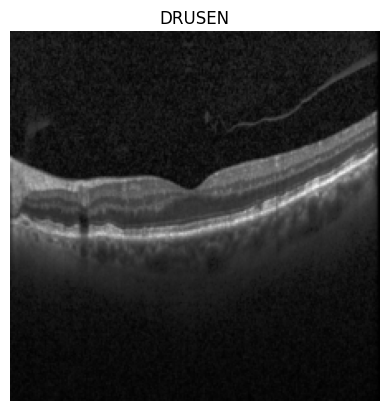

In [22]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [134]:
model = SwinTransformer(num_classes=len(class_names))

In [23]:
sys.path.append('/content/drive/MyDrive/01_Deep_Learning/model_swin')
import engine

In [24]:
from helper_functions import set_seeds

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [44]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4686 | train_acc: 0.2536 | test_loss: 1.3880 | test_acc: 0.2500
Epoch: 2 | train_loss: 1.3866 | train_acc: 0.2466 | test_loss: 1.3865 | test_acc: 0.2500
Epoch: 3 | train_loss: 1.3865 | train_acc: 0.2519 | test_loss: 1.3863 | test_acc: 0.2500
Epoch: 4 | train_loss: 1.3864 | train_acc: 0.2459 | test_loss: 1.3863 | test_acc: 0.2500
Epoch: 5 | train_loss: 1.3865 | train_acc: 0.2420 | test_loss: 1.3864 | test_acc: 0.2500
Epoch: 6 | train_loss: 1.3865 | train_acc: 0.2426 | test_loss: 1.3863 | test_acc: 0.2500
Epoch: 7 | train_loss: 1.3864 | train_acc: 0.2519 | test_loss: 1.3864 | test_acc: 0.2500
Epoch: 8 | train_loss: 1.3863 | train_acc: 0.2547 | test_loss: 1.3864 | test_acc: 0.2500
Epoch: 9 | train_loss: 1.3865 | train_acc: 0.2486 | test_loss: 1.3864 | test_acc: 0.2500
Epoch: 10 | train_loss: 1.3864 | train_acc: 0.2494 | test_loss: 1.3864 | test_acc: 0.2500


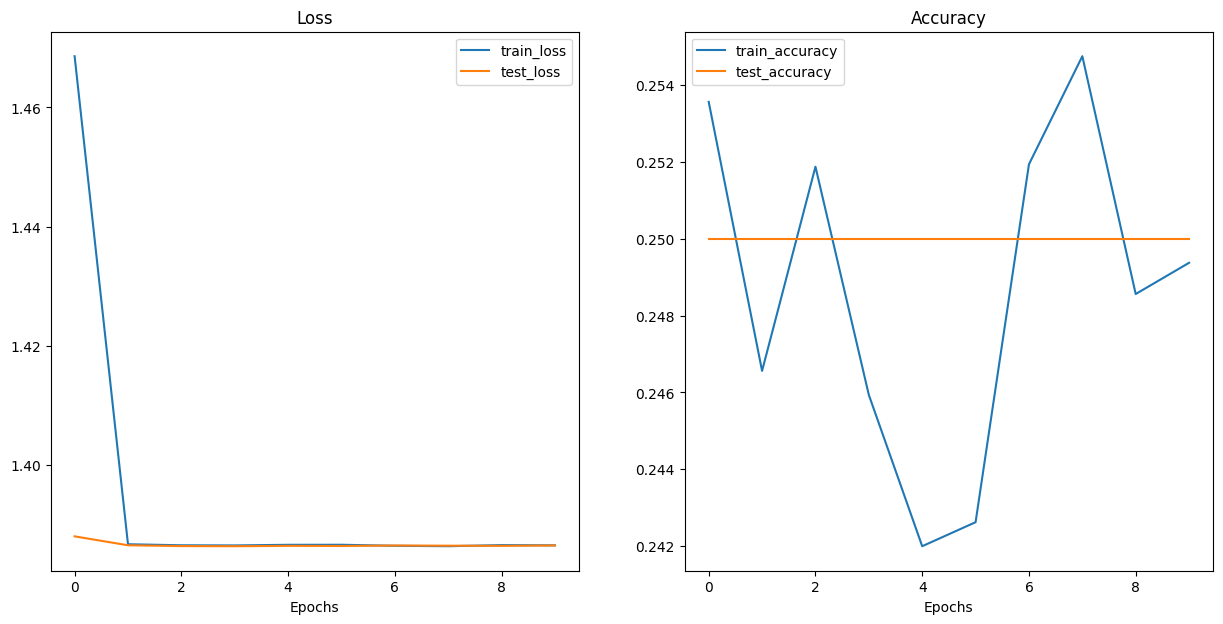

In [45]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

## Version 2 and with Pretrained Model

In [2]:
pip install torch torchvision timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.9 MB/s eta 0:00:00


In [23]:
import torch
from timm.models import swin_transformer_v2
from urllib.request import urlopen
from PIL import Image
import timm

model = timm.create_model('swin_small_patch4_window7_224.ms_in22k_ft_in1k', pretrained=True)
model = model.eval()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [25]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5465 | train_acc: 0.2516 | test_loss: 1.4043 | test_acc: 0.2500
Epoch: 2 | train_loss: 1.5235 | train_acc: 0.2481 | test_loss: 1.4193 | test_acc: 0.2500
Epoch: 3 | train_loss: 1.4792 | train_acc: 0.2458 | test_loss: 1.3999 | test_acc: 0.2500
Epoch: 4 | train_loss: 1.4380 | train_acc: 0.2507 | test_loss: 1.4200 | test_acc: 0.2500
Epoch: 5 | train_loss: 1.4177 | train_acc: 0.2462 | test_loss: 1.4022 | test_acc: 0.2500
Epoch: 6 | train_loss: 1.4136 | train_acc: 0.2481 | test_loss: 1.4095 | test_acc: 0.2500
Epoch: 7 | train_loss: 1.4203 | train_acc: 0.2515 | test_loss: 1.4057 | test_acc: 0.2500
Epoch: 8 | train_loss: 1.4135 | train_acc: 0.2497 | test_loss: 1.4002 | test_acc: 0.2500
Epoch: 9 | train_loss: 1.4153 | train_acc: 0.2507 | test_loss: 1.4037 | test_acc: 0.2500
Epoch: 10 | train_loss: 1.4133 | train_acc: 0.2473 | test_loss: 1.4034 | test_acc: 0.2500


In [38]:
!pip install transformers --upgrade

In [39]:
from transformers import SwinTransformerV2ForImageClassification

ImportError: ignored

In [36]:
pretrained_model = SwinTransformerV2ForImageClassification.from_pretrained('swin_base_patch4_window7_224', num_labels=num_classes)
model = nn.Sequential(pretrained_model.backbone, nn.Linear(pretrained_model.backbone.num_features, num_classes))

ImportError: ignored

In [32]:
!pip install torchvision

In [40]:
pip install timm

In [43]:
import torch
from torch import nn
from timm.models.swin_transformer import swin_base_patch4_window7_224 as swin_transformer_v2

In [53]:
pretrained_model = swin_transformer_v2(pretrained=True)

In [55]:
from timm.loss import LabelSmoothingCrossEntropy
from timm.utils import accuracy

In [59]:
criterion = LabelSmoothingCrossEntropy()
optimizer = torch.optim.AdamW(pretrained_model.parameters(), lr=1e-3, weight_decay=1e-6)

num_epochs = 10

for epoch in range(num_epochs):
    pretrained_model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = pretrained_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        pretrained_model.eval()
    total_correct = 0
    num_examples = 0
    with torch.no_grad():
        for inputs, labels in valid_dataloader:
            outputs = pretrained_model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            total_correct += (predicted == labels).sum().item()
            num_examples += labels.size(0)


print(f'Epoch: {epoch + 1}, Accuracy: {total_correct / num_examples * 100:.2f}%')


KeyboardInterrupt: ignored

In [64]:
pretrained_model

AttributeError: ignored

In [67]:
total_correct = 0
num_examples  0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = pretrained_model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        total_correct += (predicted == labels).sum().item()
        num_examples += labels.size(0)

print(f'Test Accuracy: {total_correct / num_examples * 100:.2f}%')

Test Accuracy: 25.00%


In [66]:
# Count trainable parameters
total_params = sum(p.numel() for p in pretrained_model.parameters() if p.requires_grad)

print("Total trainable parameters:", total_params)

Total trainable parameters: 87768224
